In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
sys.path.append('/home/jb07/nipype_installation/')

In [4]:
from IPython.display import display
from ipywidgets import FloatProgress

In [5]:
import os
from nilearn import plotting
import pandas as pd
import re
from scipy.stats import pearsonr, pearsonr, sem, ttest_ind, mannwhitneyu, zscore
import seaborn as sns
from statsmodels.formula.api import ols
from subprocess import call

In [6]:
mm2inches = 0.039371

In [149]:
def get_imaging_ID(ID_string, ID_table):
    """
    Function to match behavioural an imaging IDs
    """
    
    # Reading data from the lookup table
    import pandas as pd
    data = pd.Series.from_csv(ID_table)

    # Removing brackts
    import re
    for counter in range(1,len(data)):
        entry = data[counter]
        if re.search(r"[(){}[\]]+",str(entry)):
            data[counter] = entry[1:-1]

    # Getting the matching ID
    try:
        ID = data[data.index == ID_string].values.tolist()
        return ID[0]
    except:
        return float('nan')

In [134]:
in_folder = '/imaging/jb07/CALM/BrainTypes/CALM/rsfMRI/'

In [135]:
subject_list = sorted([subject.split('/')[8] for subject in pd.read_csv(in_folder + 'Melodic.gica/.filelist', header=None)[0].values])

### Images of the components with high correlation to the Yeo et al. default mode network

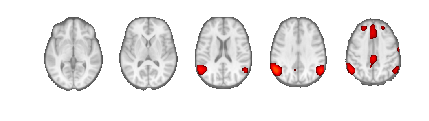

In [13]:
bg_img = '/imaging/jb07/Atlases/Yeo_JNeurophysiol11_MNI152/CALM_template_FreeSurferConformed_1mm.nii.gz'

for map in [9]:
    stat_map = '/imaging/jb07/CALM/BrainTypes/CALM/rsfMRI/presentation/1Nov_thresh_zstat' + str(map) + '.nii.gz'
    
    fig = plt.figure(figsize=(95*mm2inches, 0.2*95*mm2inches), dpi=300, tight_layout=True, facecolor='white', frameon=True)
    plotting.plot_stat_map(stat_map, 
                           bg_img=bg_img,
                           threshold=3,
                           vmax=10.0, 
                           display_mode='z',
                           cut_coords=[0, 10, 20, 30, 40],
                           black_bg = False,
                           figure=fig,
                           annotate=False,
                           colorbar=False)
    plt.savefig('../results/figures/ICA_' + str(map) + '.png', dpi=300)

## Group comparison

In [21]:
calm_grouped = pd.read_csv('../data/derived_data/CALM_grouped.csv')
calm_grouped = calm_grouped.set_index('Unnamed: 0')
calm_grouped = calm_grouped[calm_grouped['region'] == 'Cing L']

Comparing quality

In [33]:
quality_df = pd.read_csv('../data/derived_data/CALM_rsfMRI_data_quality_additional_measures.csv')
quality_df.columns = ['MRI.ID', 'mean_motion', 'number_of_outliers']
quality_df = quality_df[quality_df['MRI.ID'].isin(subject_list)]
quality_df = quality_df.set_index('MRI.ID')

In [98]:
combined_df = pd.merge(calm_grouped, quality_df, left_index=True, right_index=True)

In [51]:
for measure in ['mean_motion', 'number_of_outliers']:
    mean =  combined_df.groupby('group')[measure].mean().values
    se = combined_df.groupby('group')[measure].apply(sem).values
    df = len(combined_df) - 2
    t,p = ttest_ind(combined_df[combined_df['group'] == 1][measure].values, combined_df[combined_df['group'] == 2][measure].values)
    print('group 1: mean=%.2f, SE=%.3f; group2: mean=%.2f, SE=%.3f, t(%i)=%.2f, p=.%.3f' % (mean[1], se[1], mean[2], se[2], df, t, p))

group 1: mean=0.01, SE=0.001; group2: mean=0.01, SE=0.004, t(122)=-0.71, p=.0.480
group 1: mean=18.05, SE=1.007; group2: mean=17.08, SE=1.154, t(122)=0.63, p=.0.529


Sample description

In [91]:
print('Gender: male=%i' % combined_df['Gender(1=male)'].value_counts()[1])
print('Group: group1=%i' % combined_df['Gender(1=male)'].value_counts()[1])
print('Age: mean=%.2f, SE=%.3f' % (combined_df['Age_in_months'].mean()/12, sem(combined_df['Age_in_months'].values)/12))

Gender: male=78
Age: mean=10.00, SE=0.196


Comparison between main sample and rsfMRI sample

In [116]:
df = calm_behaviour['Age_in_months'].values.shape[0] + combined_df['Age_in_months'].values.shape[0] - 2
t,p = ttest_ind(calm_behaviour['Age_in_months'].values, combined_df['Age_in_months'].values)
print('Comparison: t(%i)=%.2f, p=%.3f' % (df, t, p))

Comparison: t(284)=-0.74, p=0.458


In [117]:
for measure in measures:
    df = calm_behaviour[measure].values.shape[0] + combined_df[measure].values.shape[0] - 2
    t,p = ttest_ind(calm_behaviour[measure].values, combined_df[measure].values)
    print('Comparison: t(%i)=%.2f, p=%.3f' % (df, t, p))

Comparison: t(284)=-0.85, p=0.396
Comparison: t(284)=-0.80, p=0.423
Comparison: t(284)=-0.73, p=0.465
Comparison: t(284)=-0.62, p=0.539
Comparison: t(284)=-0.80, p=0.427
Comparison: t(284)=-0.23, p=0.820
Comparison: t(284)=-0.74, p=0.461


### Comparing activation

In [150]:
file = open('/imaging/jb07/CALM/BrainTypes/CALM/rsfMRI/Melodic_30Oct17+.gica/.filelist', 'r')
rsfMRI_subjects = [line.split('/')[8] for line in file]
file.close()

In [151]:
calm_grouped = pd.read_csv('../data/derived_data/CALM_grouped.csv')
calm_grouped.columns = ['MRI.ID', 'value', 'region', 'group']
calm_grouped = calm_grouped[calm_grouped['region'] == 'Cing L']
calm_grouped = calm_grouped.groupby('MRI.ID').mean()
calm_grouped = calm_grouped[calm_grouped.index.isin(rsfMRI_subjects)]

In [152]:
calm_details = pd.read_csv('../data/raw_data/CALM_behavioural_data_Apr17.csv')[['ID No.', 'Gender(1=male)', 'Age_in_months', 'Matrix_Reasoning_Raw']]
calm_details = calm_details.dropna()
calm_details['MRI.ID'] = [get_imaging_ID(str(int(ID)), '../data/raw_data/MRI_ID_match_Aug17.csv') for ID in calm_details['ID No.']]
calm_details = calm_details.set_index('MRI.ID')

In [153]:
correlation_df = pd.read_csv('/home/jb07/joe_python/GitHub/BrainTypes/data/derived_data/rsfMRI_correlation.csv')
correlation_df = correlation_df[['correlation', 'partial_correlation', 'subject']]
correlation_df.columns = ['correlation','partial_correlation', 'MRI.ID']
correlation_df = correlation_df.set_index('MRI.ID')
correlation_df = correlation_df.dropna()

In [154]:
calm_details = calm_details[calm_details.index.isin(correlation_df.index)]
combined_df = pd.merge(calm_details, correlation_df, left_index=True, right_index=True)
combined_df = pd.merge(combined_df, calm_grouped, left_index=True, right_index=True)
combined_df[['partial_correlation', 'value', 'Matrix_Reasoning_Raw']] = combined_df[['partial_correlation', 'value', 'Matrix_Reasoning_Raw']].apply(zscore)

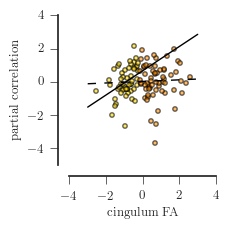

In [155]:
sns.set_style("ticks")
sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})

colours = ['#FFD700', '#FF8C00']
styles = ['solid', 'dashed']

fig, ax1 = plt.subplots(figsize=(60*mm2inches, 60*mm2inches), dpi=300)

for group in [1, 2]:
    temp_df = combined_df[combined_df['group'] == group]
    x = temp_df['value'].values
    y = temp_df['partial_correlation'].values
    plt.scatter(x, y, s=10, alpha=0.6,
               edgecolor='k', facecolor=colours[group-1])
    
    # add linear fit
    fit = ols('partial_correlation ~ value', data=temp_df).fit()
    newX = np.linspace(-3, 3, 100)
    plt.plot(newX, fit.predict({'value':newX}), 
             color='k', linestyle=styles[group-1])
sns.despine(offset=8, trim=True)
plt.xlabel('cingulum FA')
plt.ylabel('partial correlation')
ax = plt.gca()
ax.set_xticks(np.arange(-4, 6, 2))
ax.set_yticks(np.arange(-4, 6, 2))
plt.tight_layout()
plt.savefig('../results/figures/rsfMRI_moderation.png', dpi=600)

In [465]:
calm_details = calm_details[calm_details.index.isin(correlation_df.index)]
combined_df = pd.merge(calm_details, correlation_df, left_index=True, right_index=True)
combined_df = pd.merge(combined_df, calm_grouped, left_index=True, right_index=True)
group1 = combined_df[combined_df['group'] == 1]['partial_correlation']
group2 = combined_df[combined_df['group'] == 2]['partial_correlation']
print('C1: mean=%.2f, SE=%.3f' % (np.mean(group1), sem(group1)))
print('C2: mean=%.2f, SE=%.3f' % (np.mean(group2), sem(group2)))
print('Comparison: U=%i, p=%.3f' % mannwhitneyu(group1, group2))

C1: mean=0.31, SE=0.020
C2: mean=0.32, SE=0.020
Comparison: U=1511, p=0.239


In [466]:
group1 = combined_df[combined_df['group'] == 1]['value']
group2 = combined_df[combined_df['group'] == 2]['value']
mannwhitneyu(group1, group2)

MannwhitneyuResult(statistic=0.0, pvalue=1.7606397287494126e-20)

In [467]:
combined_df['Age_in_months'] = zscore(combined_df['Age_in_months'])

In [468]:
combined_df[['partial_correlation', 'value', 'Matrix_Reasoning_Raw', 'group']].to_csv('/home/jb07/Desktop/mediation.csv')

In [418]:
temp_df = combined_df[combined_df['group'] == 2].copy()
temp_df[['partial_correlation', 'value']] = temp_df[['partial_correlation', 'value']].apply(zscore)
ols('partial_correlation ~ value', data=temp_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     partial_correlation   R-squared:                       0.001
Model:                             OLS   Adj. R-squared:                 -0.015
Method:                  Least Squares   F-statistic:                   0.05745
Date:                 Wed, 15 Nov 2017   Prob (F-statistic):              0.811
Time:                         15:41:09   Log-Likelihood:                -89.363
No. Observations:                   63   AIC:                             182.7
Df Residuals:                       61   BIC:                             187.0
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.388e-17      0.128   1.08e-16      1.000        -0.256     0.256
value          0.0307      0.128      0.240      0.811        -0.225     0.287
==============================================================================
Omnibus:                       13.840   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.966
Skew:                          -0.906   Prob(JB):                     0.000207
Kurtosis:                       4.783   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [475]:
correlation_df = pd.read_csv('/home/jb07/joe_python/GitHub/BrainTypes/data/derived_data/rsfMRI_correlation.csv')
correlation_df = correlation_df[['correlation', 'partial_correlation', 'subject']]
correlation_df.columns = ['correlation','partial_correlation', 'MRI.ID']
correlation_df = correlation_df.set_index('MRI.ID')

In [476]:
calm_grouped = pd.read_csv('../data/derived_data/CALM_grouped.csv')
calm_grouped.columns = ['MRI.ID', 'value', 'region', 'group']
calm_grouped = calm_grouped[calm_grouped['region'] == 'Cing L']
calm_grouped = calm_grouped.groupby('MRI.ID').mean()
calm_grouped = calm_grouped[calm_grouped.index.isin(rsfMRI_subjects)]

## Individual IC analysis

Comparison of the number of ICs between the groups

In [198]:
calm_grouped = pd.read_csv('../data/derived_data/CALM_grouped.csv')
calm_grouped.columns = ['MRI.ID', 'value', 'region', 'group']
calm_grouped = calm_grouped[calm_grouped['region'] == 'Cing L']
calm_grouped = calm_grouped.groupby('MRI.ID').mean()

IC_df = pd.read_csv('/home/jb07/joe_python/GitHub/BrainTypes/data/derived_data/IC_matching.csv').set_index('MRI.ID')
combined_df = pd.merge(calm_grouped, IC_df, left_index=True, right_index=True)

group1 = combined_df[combined_df['group'] == 1]['number_of_components']
group2 = combined_df[combined_df['group'] == 2]['number_of_components']
print('C1: mean=%.2f, SE=%.3f; C2: mean=%.2f, SE=%.3f' % (np.mean(group1), sem(group1), np.mean(group2), sem(group2)))
print('Comparison: U=%i, p=%.3f' % mannwhitneyu(group1, group2))

C1: mean=100.70, SE=1.821; C2: mean=102.19, SE=1.862
Comparison: U=1549, p=0.254


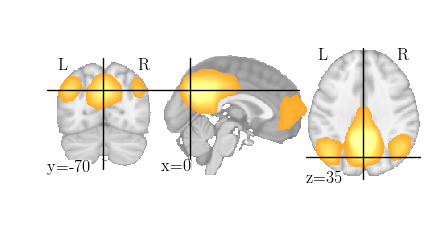

In [171]:
bg_img = '/imaging/local/software/fsl/v5.0.9/x86_64/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz'
stat_map = '/imaging/jb07/CALM/BrainTypes/CALM/rsfMRI/presentation/14Nov17_thresh_zstat8.nii.gz'
    
fig = plt.figure(figsize=(95*mm2inches, 50*mm2inches), dpi=600, tight_layout=True, facecolor='white', frameon=True)
plotting.plot_stat_map(stat_map, 
                       bg_img=bg_img,
                       cut_coords=(0, -70, 35),
                       cmap='afmhot',
                       black_bg = False,
                       threshold=3,
                       vmax=20,
                       figure=fig,
                       annotate=True,
                       colorbar=False)
plt.savefig('../results/figures/IndividualIC_group.png', dpi=600)

### 1. Comparison of spatial extent

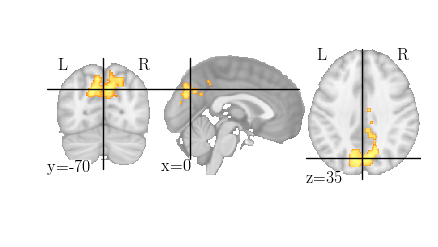

In [169]:
sns.set_style("ticks")
sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})

bg_img = '/imaging/local/software/fsl/v5.0.9/x86_64/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz'
stat_map = '/imaging/jb07/CALM/BrainTypes/CALM/rsfMRI/individual_IC/stats/group_comp_tstat2_ROI_highres.nii.gz'
    
fig = plt.figure(figsize=(95*mm2inches, 50*mm2inches), dpi=600, tight_layout=True, facecolor='white', frameon=True)
plotting.plot_stat_map(stat_map, 
                       bg_img=bg_img,
                       cmap='afmhot',
                       black_bg = False,
                       threshold=0,
                       vmax=8,
                       figure=fig,
                       annotate=True,
                       colorbar=False)
plt.savefig('../results/figures/IndividualIC_spatial_stats.png', dpi=600)

In [ ]:
for group in [1, 2]:
    bg_img = '/imaging/local/software/fsl/v5.0.9/x86_64/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz'
    stat_map = '/imaging/jb07/CALM/BrainTypes/CALM/rsfMRI/individual_IC/group' + str(group) + '_IC_highres.nii.gz'

    fig = plt.figure(figsize=(95*mm2inches, 50*mm2inches), dpi=600, tight_layout=True, facecolor='white', frameon=True)
    plotting.plot_stat_map(stat_map, 
                           bg_img=bg_img,
                           cut_coords=(0, -70, 35),
                           draw_cross=False,
                           cmap='afmhot',
                           black_bg = False,
                           threshold=0.75,
                           vmax=3,
                           figure=fig,
                           annotate=False,
                           colorbar=False)
    plt.savefig('../results/figures/IndividualIC_spatial_group' + str(group) + '_QQR.png', dpi=600)

In [206]:
?plotting.plot_stat_map

### 2. Comparison of activation

In [200]:
# Gathering the results
in_folder = '/imaging/jb07/CALM/BrainTypes/CALM/rsfMRI/individual_IC/'

results = []
for afile in os.listdir(in_folder):
    if re.search('.txt', afile):
        results.append(pd.read_csv(in_folder + afile))

results = pd.concat(results)
results.columns = ['MRI.ID', 'best_component', 'number_of_components']

In [201]:
# Averages by group
calm_grouped = pd.read_csv('/home/jb07/joe_python/GitHub/BrainTypes/data/derived_data/CALM_grouped.csv')
calm_grouped.columns = ['MRI.ID', 'value', 'region', 'group']
calm_grouped = calm_grouped[calm_grouped['region'] == 'Cing L']
calm_grouped = calm_grouped[calm_grouped['MRI.ID'].isin(results['MRI.ID'].values)]
calm_grouped = calm_grouped[calm_grouped['group'].isin([1,2])]

In [203]:
# Comparing activation
activations = []

for subject in sorted(calm_grouped['MRI.ID'].values):
    subject_folder = '/imaging/jb07/CALM/BrainTypes/CALM/rsfMRI/preprocessed/' + subject + '/' + subject + '_functional_15Nov17_indICA.ica/'
    time_courses = subject_folder + 'filtered_func_data.ica/melodic_mix'
    time_courses = pd.read_csv(time_courses, delim_whitespace=True).values

    comp = results[results['MRI.ID'] == subject]['best_component'].values[0]
    activations.append(np.sum(time_courses[:, comp-1]))

from scipy.stats import mannwhitneyu, ttest_ind
calm_grouped['activation'] = zscore(activations)

group1 = calm_grouped[calm_grouped['group'] == 1]['activation'].values
group2 = calm_grouped[calm_grouped['group'] == 2]['activation'].values
print('C1: mean=%.2f, SE=%.3f; C2: mean=%.2f, SE=%.3f' % (np.mean(group1), sem(group1), np.mean(group2), sem(group2)))
print('Comparison: U=%i, p=%.4f' % mannwhitneyu(group1, group2))

C1: mean=-0.16, SE=0.137; C2: mean=0.13, SE=0.126
Comparison: U=1372, p=0.0499


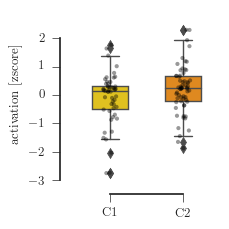

In [204]:
sns.set_style("ticks")
sns.set_style({'axes.grid': False,
           'font.family': [u'serif'],
           'font.size': 9,
           'font.sans-serif': [u'Computer Modern Unicode'],})
my_palette = sns.color_palette(['#FFD700', '#FF8C00', '#D3D3D3'])
 
fig = plt.figure(figsize=(60*mm2inches, 60*mm2inches), dpi=600, tight_layout=True, facecolor='white', frameon=True)
calm_grouped = calm_grouped[abs(calm_grouped['activation']) < 3]
sns.boxplot(x='group', y='activation', palette=my_palette, width=0.5, data=calm_grouped)
sns.stripplot(x='group', y='activation', color='k', size=3, alpha=0.4, jitter=True, data=calm_grouped)
plt.ylim([-3, 3])
plt.xlabel(' ')
plt.ylabel('activation [zscore]')
ax = plt.gca()
ax.set_xticklabels(['C1', 'C2'])
ax.set_yticks(np.arange(-3, 3))
sns.despine(offset=10, trim=True)
plt.savefig('../results/figures/IndividualIC_group_comp.png', dpi=600)